## ANOVA Em Dados Financeiros do Mercado de Criptoativos

## Importando as Bibliotecas

In [94]:
import requests

import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.stats import levene, bartlett

import statsmodels.api as sm
import matplotlib.pyplot as plt

### Construindo uma Base de Dados Financeiros com Ações Do Mercado De Criptoativos

O Mercado Bitcoin, maior corretora de criptomoedas da América Latina, disponibiliza uma [API pública](https://www.mercadobitcoin.com.br/api-doc/#method_trade_api_daysummary) onde é possível consultar o resumo diário de negociações realizadas para um dado criptoativo.


Realizando a seguinte [chamada](https://www.mercadobitcoin.net/api/BTC/day-summary/2022/6/29/) tem-se os dados de negociação (compra e venda) do criptoativo \textit{Bitcoin} (BTC) para o dia 29/06/2022. Desta maneira, serão realizadas chamadas a API pública com intuito de construir uma Base de Dados com os ativos BITCOIN(BTC), CARDANO (ADA), LITECOIN(LTC), CHILIZ(CHZ), USDC, NANO(LINK) ao longo dos anos de 2020 a 2022, em todos os dias e meses do ano.

In [2]:
ativos = {"BITCOIN": "BTC", "CARDANO": "ADA", "LITECOIN": "LTC", "CHILIZ": "CHZ", "USDC": "USDC", "NANO": "LINK"}
anos = [2020, 2021, 2022]
meses = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dias = list(range(1, 32))

In [ ]:
resumo_ativos = []
url_resumo_diario = "https://www.mercadobitcoin.net/api/{ativo}/day-summary/{ano}/{mes}/{dia}/"

for ativo in ativos.values():
    print(ativo)
    resumo_ativo = []
    for ano in anos:
        print(ano)
        for mes in meses:
            # pular os meses futuros do ano de 2022
            if ano == 2022 and mes > 7:
                continue
            for dia in dias:
                # pular os dias futuros de julho de 2022
                if ano == 2022 and mes == 7 and dia >= 25:
                    continue
                url_dia_formatada = url_resumo_diario.format(ativo=ativo,ano=ano, mes=mes, dia=dia)
                resposta = requests.get(url=url_dia_formatada)
                if resposta.status_code == 200:
                    resumo_ativo.append(resposta.json())
                else:
                    continue
    resumo_ativos.append(resumo_ativo)

In [ ]:
resumo_ativos

In [25]:
acoes_df = pd.DataFrame()

for ativo, resumo in zip(ativos, resumo_ativos):
    indice = [r["date"] for r in resumo]
    acoes_df[ativo] = pd.DataFrame(resumo)["closing"]

# acoes_df["Date"] = [r["date"] for r in resumo_ativos[0]]
acoes_df

,BITCOIN,CARDANO,LITECOIN,CHILIZ,USDC,NANO
0,29118.000000,12.89956,167.09015,0.07000,5.44500,60.37949
1,28010.000000,12.43990,160.94876,0.06800,5.38850,62.54979
2,29670.481710,12.40000,170.29813,0.06540,5.46790,64.27989
3,30000.991580,12.33131,173.06007,0.06510,5.44001,65.48000
4,30199.990000,12.07408,177.90000,0.06439,5.39874,65.57001
...,...,...,...,...,...,...
949,125000.000000,NaN,304.00004,NaN,NaN,NaN
950,126708.000000,NaN,318.47012,NaN,NaN,NaN
951,126017.000000,NaN,311.44263,NaN,NaN,NaN
952,124115.769950,NaN,313.65668,NaN,NaN,NaN


In [26]:
for coluna in acoes_df:
    acoes_df[coluna].fillna(acoes_df[coluna].mean(), inplace=True)
acoes_df

,BITCOIN,CARDANO,LITECOIN,CHILIZ,USDC,NANO
0,29118.000000,12.899560,167.09015,0.070000,5.445000,60.379490
1,28010.000000,12.439900,160.94876,0.068000,5.388500,62.549790
2,29670.481710,12.400000,170.29813,0.065400,5.467900,64.279890
3,30000.991580,12.331310,173.06007,0.065100,5.440010,65.480000
4,30199.990000,12.074080,177.90000,0.064390,5.398740,65.570010
...,...,...,...,...,...,...
949,125000.000000,5.946881,304.00004,1.091287,5.359013,115.072929
950,126708.000000,5.946881,318.47012,1.091287,5.359013,115.072929
951,126017.000000,5.946881,311.44263,1.091287,5.359013,115.072929
952,124115.769950,5.946881,313.65668,1.091287,5.359013,115.072929


### Teste de Homogeneidade da variância do Erro

Pretende-se comparar os criptoativos em relação ao USDC. Por se tratar de uma *stablecoin*, isto é, tem o seu valor lastreado em uma moeda fiduciária, neste caso, o Dólar Americano. A criptomoeda USDC servirá de base de comparação com as demais, tendo em vista que o seu valor representa o valor do Dólar Americano à época.

In [67]:
estatistica_F, p_valor

(762.9414236826264, 1.5459366138282837e-141)

In [79]:
levene_df = pd.DataFrame(columns=[k for k in ativos.keys() if k != "USDC"], index=["estatistica_F", "p_valor"])

for coluna in levene_df:
    levene_df[coluna] = levene(acoes_df["USDC"], acoes_df[coluna])

levene_df

,BITCOIN,CARDANO,LITECOIN,CHILIZ,NANO
estatistica_F,3068.42429,1.557726e+02,1.791099e+03,5.163369e+02,7.629414e+02
p_valor,0.00000,2.021245e-34,1.601442e-276,2.389128e-101,1.545937e-141


In [83]:
bartlett_df = pd.DataFrame(columns=[k for k in ativos.keys() if k != "USDC"], index=["K_squared", "p_valor"])

for coluna in bartlett_df:
    bartlett_df[coluna] = bartlett(acoes_df["USDC"], acoes_df[coluna])

bartlett_df

,BITCOIN,CARDANO,LITECOIN,CHILIZ,NANO
K_squared,23349.312833,2483.70839,12745.147401,1.183827e+03,8533.816943
p_valor,0.000000,0.00000,0.000000,1.996110e-259,0.000000


### Gráfico de Avaliação de Normalidade dos Resíduos

In [86]:
anova_df = pd.DataFrame(columns=[k for k in ativos.keys() if k != "USDC"], index=["f_valor", "p_valor"])

for coluna in anova_df:
    anova_df[coluna] = stats.f_oneway(acoes_df["USDC"], acoes_df[coluna])

anova_df

,BITCOIN,CARDANO,LITECOIN,CHILIZ,NANO
f_valor,2527.832856,1.087859e+02,2423.398567,23891.813156,6482.705866
p_valor,0.000000,8.293112e-25,0.000000,0.000000,0.000000


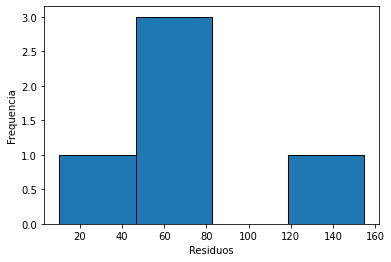

In [98]:
# histograma
plt.hist(np.sqrt(anova_df.iloc[0]), bins="auto", histtype="bar", ec="k") 
plt.xlabel("Residuos")
plt.ylabel("Frequencia")
plt.show()

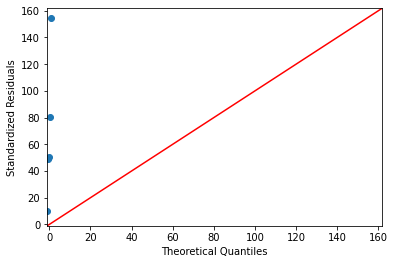

In [102]:
sm.qqplot(np.sqrt(anova_df.iloc[0]), line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()